In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")

In [5]:
def individual_generator(id_=-1, cb_init=None):
    return Solution(GRNMain(5, 0, 1, generate_funcs=cb_init), id_=id_)

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    s_prog = score_stats_norm(bb.stats, ref.stats, col_stats=f"progenitor_pop_size",
                     col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
    s_all = score_stats_norm(bb.stats, ref.stats, col_stats=f"whole_pop_size",
                     col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
    s_neuron = score_stats_norm(bb.stats, ref.stats, col_stats=f"neuron_pop_size",
                     col_ref="neuron_pop_size", col_norm_data="progenitor_pop_size",
                       col_norm_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)

    return np.mean(s_prog + s_all + s_neuron)

In [8]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [9]:
def get_bb(prun, grn):
    ccls = factories["grn4"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=False, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [10]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [11]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [12]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = [p**prun.exponent for p in pop_fit]
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=0.5, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [13]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 3
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    # ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    # ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="10", start_time=77, end_time=80, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="11", start_time=80, end_time=83, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="12", start_time=83, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=2):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [14]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [18]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // 100
            exporter(pop[-prun.max_pop:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [16]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0,
)

In [19]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "checkperf_2102_v2"
res = main(prun)

Exporting at output/checkperf_2102_v2
[definition] 
    
    
[reload] Found generation 6
Step 3 passed !
Step 4 passed !
Step 5 passed !
Step 6 passed !
Step 7 passed !
Step 8 passed !
[out] ++ Best 1.9254254972044482 for generation 350
Step 9 passed !
Step 10 passed !
Step 11 passed !
Step 12 passed !
[out] ++ Best 6.943328839971222 for generation 351
[out] ++ Best 7.919231568242425 for generation 368
Saving ...
[out] Step 400
[out] ++ Best 8.47692767745044 for generation 402
Saving ...
Saving ...
[out] Step 500
[out] ++ Best 8.725214198204718 for generation 509
Saving ...
Saving ...
[out] Step 600
Saving ...
[out] ++ Best 9.108306227051319 for generation 665
Saving ...
[out] Step 700
Saving ...
Saving ...
[out] Step 800
Saving ...
Saving ...
[out] Step 900
Saving ...
Saving ...
[out] Step 1000
Saving ...
Saving ...
[out] Step 1100
Saving ...
Saving ...
[out] Step 1200
Saving ...
Saving ...
[out] Step 1300
Saving ...
Saving ...
[out] Step 1400
Saving ...
Saving ...
[out] Step 1500
Sa

In [ ]:
show_curve(res.stats, REF.stats)

In [20]:
print(1)

1


In [21]:
exp = Exporter(name=prun.name)

Exporting at output/checkperf_2102_v2


In [22]:
def pick_last(exp, sm=None):
    if sm is None:
        sm = read_model("generation")
    return sm.pick_last(sorted(exp.list()), slot="generation")

def pick_best(res):
    return res[res.index(max(res, key=lambda x: x.fit))]

In [23]:
res = pick_best(exp.load(pick_last(exp)))

In [26]:
sm = read_model("generation")

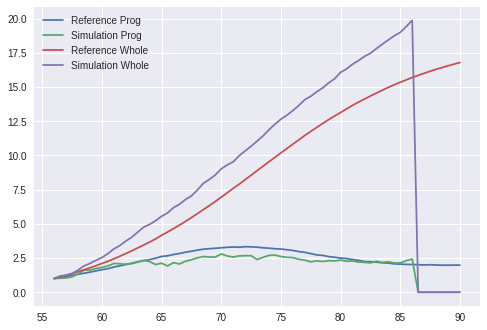

In [24]:
show_curve(res.stats, REF.stats)

In [27]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} =======")
    print(res.grn)


======= GENERATION generation_g0 =======
>> G_0: init: 1.49; noise: 9.97; b: 2.66; m: 8.19; expr: 1.00; deg: 0.00; theta: 1.60; asym: 2.23; tree : 4
>> G_1: init: 1.08; noise: 1.35; b: 0.85; m: 1.58; expr: 1.00; deg: 0.00; theta: 2.38; asym: 1.52; tree : 2
>> G_2: init: 1.98; noise: 2.76; b: 3.97; m: 6.58; expr: 1.00; deg: 0.00; theta: 9.64; asym: 1.10; tree : NOT NOT 4
>> G_3: init: 0.95; noise: 9.43; b: 1.66; m: 8.54; expr: 1.00; deg: 0.00; theta: 6.12; asym: 3.78; tree : 4
>> G_4: init: 1.65; noise: 4.40; b: 0.76; m: 9.48; expr: 1.00; deg: 0.00; theta: 7.88; asym: 2.07; tree : 0

======= GENERATION generation_g1 =======
>> G_0: init: 1.27; noise: 4.23; b: 1.30; m: 7.23; expr: 1.00; deg: 0.00; theta: 1.64; asym: 4.59; tree : (NOT 1 AND 0)
>> G_1: init: 1.45; noise: 6.22; b: 1.66; m: 9.86; expr: 1.00; deg: 0.00; theta: 4.52; asym: 5.63; tree : 1
>> G_2: init: 0.70; noise: 4.09; b: 4.11; m: 7.12; expr: 1.00; deg: 0.00; theta: 9.23; asym: 0.62; tree : 1
>> G_3: init: 1.22; noise: 5.11;